<a href="https://colab.research.google.com/github/vinayak-pathak/pyprac_f/blob/master/Earth_Mover_Distance_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install tensorflow_datasets
!pip3 install tensorflow-gpu==2.0.0-rc0

In [ ]:
!nvidia-smi

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)

2.0.0-rc0


In [ ]:
# Get Data
BATCH_SIZE = 100
TOTAL_SIZE = 1309
test = tfds.Split.TRAIN.subsplit(tfds.percent[-25:])
train = tfds.Split.TRAIN.subsplit(tfds.percent[:75])
train_ds = tfds.load('titanic', split=train)
test_ds = tfds.load('titanic', split=test)

train_ds = train_ds.map(lambda ele: tuple((ele['features'], ele['survived']))).batch(BATCH_SIZE).repeat()
test_ds = test_ds.map(lambda ele: tuple((ele['features'], ele['survived']))).batch(BATCH_SIZE).repeat()

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


W0903 04:35:26.431784 139704197355392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset titanic downloaded and prepared to /root/tensorflow_datasets/titanic/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def preview_data(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  return feature_layer(feature_batch).numpy()

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))

Every feature: ['age', 'boat', 'body', 'cabin', 'embarked', 'fare', 'home.dest', 'name', 'parch', 'pclass', 'sex', 'sibsp', 'ticket']


In [ ]:

pclass = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_identity('pclass', 3)
         )
home = tf.feature_column.indicator_column(
          tf.feature_column.categorical_column_with_hash_bucket('home.dest', 50)
       )

age = tf.feature_column.numeric_column('age')
sex = tf.feature_column.numeric_column('sex')
sibsp = tf.feature_column.numeric_column('sibsp')
parch = tf.feature_column.numeric_column('parch')
fare = tf.feature_column.numeric_column('fare')

feature_columns = [age, sex, sibsp, parch, fare, home, pclass]

In [ ]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sex', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sibsp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=HashedCategoricalColumn(key='home.dest', hash_bucket_size=50, dtype=tf.string)),
 IndicatorColumn(categorical_column=IdentityCategoricalColumn(key='pclass', number_buckets=3, default_value=None))]

In [ ]:
preview_data(feature_columns).shape

(100, 58)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile('adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.fit(train_ds, steps_per_epoch=int(TOTAL_SIZE*0.75), 
          validation_data=test_ds, 
          validation_steps=int(TOTAL_SIZE*0.25),
          epochs=10)

In [ ]:
model.summary()

In [ ]:
# Functional API method
feature_layer_inputs = {
    'age': tf.keras.Input(shape=(1,), name='age'),
    'sex': tf.keras.Input(shape=(1,), name='sex'),
    'sibsp': tf.keras.Input(shape=(1,), name='sibsp'),
    'parch': tf.keras.Input(shape=(1,), name='parch'),
    'fare': tf.keras.Input(shape=(1,), name='fare'),
    'home.dest': tf.keras.Input(shape=(1,), name='home.dest', dtype=tf.string),
    'pclass': tf.keras.Input(shape=(1,), name='pclass', dtype=tf.int32)
}

feature_layer_outputs = tf.keras.layers.DenseFeatures(feature_columns)(feature_layer_inputs)
x = tf.keras.layers.Dense(1, activation='sigmoid')(feature_layer_outputs)
model = tf.keras.models.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=x)

model.summary()

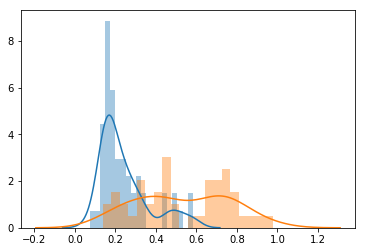

In [ ]:
import seaborn as sns
predicted_dead = model.predict(feature_batch)[label_batch==0]
predicted_alive = model.predict(feature_batch)[label_batch==1]
sns.distplot(predicted_dead, bins=20)
sns.distplot(predicted_alive, bins=20)